In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Setup**

In [14]:
# 0) Setup
# Core imports
import os, glob, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)

# Locate the dataset folder automatically (Kaggle mounts under /kaggle/input/)
CANDIDATES = glob.glob("/kaggle/input/*")
csv_names = {"orders.csv","customers.csv","campaigns.csv","channels.csv"}
DATA_DIR = None

for path in CANDIDATES:
    files = {os.path.basename(p).lower() for p in glob.glob(os.path.join(path, "*.csv"))}
    if csv_names.issubset(files):
        DATA_DIR = path
        break

assert DATA_DIR is not None, "Could not find the uploaded CSVs. Please ensure all four files are in one dataset."
print("✅ Data directory found:", DATA_DIR)


✅ Data directory found: /kaggle/input/e-commerce-etl-and-reporting-using-sql-and-python


**1) Load CSVs → Pandas (quick sanity)**

In [15]:
# 1) Load CSVs → Pandas (quick sanity check)
orders     = pd.read_csv(os.path.join(DATA_DIR, "orders.csv"))
customers  = pd.read_csv(os.path.join(DATA_DIR, "customers.csv"))
campaigns  = pd.read_csv(os.path.join(DATA_DIR, "campaigns.csv"))
channels   = pd.read_csv(os.path.join(DATA_DIR, "channels.csv"))

print("Shapes:", { 
    "orders": orders.shape, 
    "customers": customers.shape, 
    "campaigns": campaigns.shape, 
    "channels": channels.shape 
})

orders.head(3)


Shapes: {'orders': (10, 9), 'customers': (7, 5), 'campaigns': (3, 6), 'channels': (3, 2)}


,order_id,customer_id,order_date,product_id,quantity,price_per_unit,discount,payment_method,channel_id
0,O1001,C001,2024-01-03,P01,2,1200,0.10,Credit Card,CH01
1,O1002,C002,2024-01-03,P02,1,2500,0.00,UPI,CH02
2,O1003,C003,2024-01-05,P03,3,900,0.05,Cash on Delivery,CH01


**2) Create SQLite DB + Stage the raw data**

In [16]:
# 2) Create SQLite DB + Stage Raw Data
conn = sqlite3.connect("ecommerce.db")
cur  = conn.cursor()

# Stage all CSVs (replace if rerun)
orders.to_sql("stg_orders", conn, index=False, if_exists="replace")
customers.to_sql("stg_customers", conn, index=False, if_exists="replace")
campaigns.to_sql("stg_campaigns", conn, index=False, if_exists="replace")
channels.to_sql("stg_channels", conn, index=False, if_exists="replace")

print("✅ Staging tables created successfully!")


✅ Staging tables created successfully!


**3) DDL for clean (typed) tables**

In [17]:
# 3) DDL for clean (typed) tables
ddl = """
DROP TABLE IF EXISTS channels;
DROP TABLE IF EXISTS campaigns;
DROP TABLE IF EXISTS customers;
DROP TABLE IF EXISTS orders;

-- Channels
CREATE TABLE channels (
  channel_id   TEXT PRIMARY KEY,
  channel_name TEXT NOT NULL
);

-- Campaigns
CREATE TABLE campaigns (
  campaign_id   TEXT PRIMARY KEY,
  campaign_name TEXT NOT NULL,
  start_date    DATE NOT NULL,
  end_date      DATE NOT NULL,
  spend         REAL NOT NULL,
  channel_id    TEXT NOT NULL,
  FOREIGN KEY (channel_id) REFERENCES channels(channel_id)
);

-- Customers
CREATE TABLE customers (
  customer_id TEXT PRIMARY KEY,
  name        TEXT,
  city        TEXT,
  signup_date DATE NOT NULL,
  channel_id  TEXT,
  FOREIGN KEY (channel_id) REFERENCES channels(channel_id)
);

-- Orders
CREATE TABLE orders (
  order_id        TEXT PRIMARY KEY,
  customer_id     TEXT NOT NULL,
  order_date      DATE NOT NULL,
  product_id      TEXT NOT NULL,
  quantity        INTEGER NOT NULL,
  price_per_unit  REAL NOT NULL,
  discount        REAL DEFAULT 0.0,
  payment_method  TEXT,
  channel_id      TEXT,
  FOREIGN KEY (customer_id) REFERENCES customers(customer_id),
  FOREIGN KEY (channel_id)  REFERENCES channels(channel_id)
);
"""
cur.executescript(ddl)
conn.commit()
print("✅ Clean base tables created!")


✅ Clean base tables created!


**4) Load from staging → clean tables (dedup + light typing)**

In [18]:
# 4) Load Clean Data from staging (dedup + typing)
load_clean_sql = """
DELETE FROM channels;
INSERT INTO channels(channel_id, channel_name)
SELECT DISTINCT channel_id, channel_name FROM stg_channels;

DELETE FROM campaigns;
INSERT INTO campaigns(campaign_id, campaign_name, start_date, end_date, spend, channel_id)
SELECT DISTINCT c.campaign_id, c.campaign_name, c.start_date, c.end_date, c.spend, c.channel_id
FROM stg_campaigns c
JOIN channels ch ON ch.channel_id = c.channel_id;

DELETE FROM customers;
WITH ranked AS (
  SELECT *,
         ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY DATE(signup_date) DESC) AS rn
  FROM stg_customers
)
INSERT INTO customers(customer_id, name, city, signup_date, channel_id)
SELECT customer_id, name, city, signup_date, channel_id
FROM ranked
WHERE rn = 1;

DELETE FROM orders;
WITH ranked AS (
  SELECT *,
         ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY DATE(order_date) DESC) AS rn
  FROM stg_orders
)
INSERT INTO orders(order_id, customer_id, order_date, product_id, quantity, price_per_unit, discount, payment_method, channel_id)
SELECT order_id, customer_id, order_date, product_id, quantity, price_per_unit, COALESCE(discount,0), payment_method, channel_id
FROM ranked
WHERE rn = 1
  AND customer_id IN (SELECT customer_id FROM customers)
  AND channel_id IN (SELECT channel_id FROM channels);
"""
cur.executescript(load_clean_sql)
conn.commit()
print("✅ Clean data loaded successfully!")


✅ Clean data loaded successfully!


**5) Quick Data Quality Check**

In [19]:
# 5) Quick Data Quality Check
def sql(q): return pd.read_sql(q, conn)

for t in ["channels","campaigns","customers","orders"]:
    n = sql(f"SELECT COUNT(*) AS n FROM {t}").loc[0,"n"]
    print(f"{t:10s} → {n} rows")

sql("""
SELECT 'orders' AS table_name, COUNT(*) AS bad_rows
FROM orders WHERE order_id IS NULL OR customer_id IS NULL OR order_date IS NULL
UNION ALL
SELECT 'customers', COUNT(*) FROM customers WHERE customer_id IS NULL OR signup_date IS NULL
UNION ALL
SELECT 'campaigns', COUNT(*) FROM campaigns WHERE campaign_id IS NULL OR spend IS NULL;
""")


channels   → 3 rows
campaigns  → 3 rows
customers  → 7 rows
orders     → 10 rows


,table_name,bad_rows
0,orders,0
1,customers,0
2,campaigns,0


**6) Create View: v_orders_clean**

In [20]:
# 6) Create a clean orders view with computed revenue
cur.executescript("""
DROP VIEW IF EXISTS v_orders_clean;
CREATE VIEW v_orders_clean AS
SELECT o.*, 
       (o.quantity * o.price_per_unit * (1 - COALESCE(o.discount,0))) AS revenue
FROM orders o;
""")
conn.commit()
print("✅ v_orders_clean view created!")


✅ v_orders_clean view created!


**7) ROI per Campaign**

In [21]:
# 7) ROI per Campaign
cur.executescript("""
DROP VIEW IF EXISTS v_campaign_performance;
CREATE VIEW v_campaign_performance AS
SELECT
  c.campaign_id,
  c.campaign_name,
  c.channel_id,
  c.start_date,
  c.end_date,
  c.spend,
  ROUND(SUM(CASE
      WHEN DATE(o.order_date) BETWEEN DATE(c.start_date) AND DATE(c.end_date)
           AND o.channel_id = c.channel_id
      THEN o.revenue ELSE 0 END), 2) AS revenue,
  CASE WHEN c.spend > 0
       THEN ROUND(SUM(CASE
             WHEN DATE(o.order_date) BETWEEN DATE(c.start_date) AND DATE(c.end_date)
                  AND o.channel_id = c.channel_id
             THEN o.revenue ELSE 0 END) / c.spend, 2)
       ELSE NULL END AS roi
FROM campaigns c
LEFT JOIN v_orders_clean o ON o.channel_id = c.channel_id
GROUP BY c.campaign_id, c.campaign_name, c.channel_id, c.start_date, c.end_date, c.spend;
""")
conn.commit()

sql("SELECT * FROM v_campaign_performance ORDER BY start_date;")


,campaign_id,campaign_name,channel_id,start_date,end_date,spend,revenue,roi
0,CMP01,New Year Promo,CH01,2023-12-25,2024-01-05,10000.0,4725.0,0.47
1,CMP03,Winter Clearance,CH03,2024-01-10,2024-01-25,8000.0,7400.0,0.93
2,CMP02,Republic Day Sale,CH02,2024-01-20,2024-01-30,12000.0,0.0,0.00


**8) Daily KPIs**

In [22]:
# 8) Daily KPIs
cur.executescript("""
DROP VIEW IF EXISTS v_daily_kpis;
CREATE VIEW v_daily_kpis AS
SELECT
  DATE(order_date) AS order_day,
  COUNT(DISTINCT customer_id) AS unique_buyers,
  COUNT(*) AS total_orders,
  ROUND(SUM(revenue),2) AS total_revenue,
  ROUND(AVG(revenue),2) AS avg_order_value
FROM v_orders_clean
GROUP BY DATE(order_date)
ORDER BY order_day;
""")
conn.commit()

sql("SELECT * FROM v_daily_kpis;")


,order_day,unique_buyers,total_orders,total_revenue,avg_order_value
0,2024-01-03,2,2,4660.0,2330.0
1,2024-01-05,1,1,2565.0,2565.0
2,2024-01-10,1,1,4000.0,4000.0
3,2024-01-12,1,1,4000.0,4000.0
4,2024-01-13,1,1,5100.0,5100.0
5,2024-01-14,1,1,900.0,900.0
6,2024-01-18,1,1,1080.0,1080.0
7,2024-01-19,1,1,6000.0,6000.0
8,2024-01-20,1,1,2500.0,2500.0


**9) Cohort CLV Analysis**

In [23]:
# 9) Cohort CLV Analysis
cur.executescript("""
DROP VIEW IF EXISTS v_order_cohorts;
CREATE VIEW v_order_cohorts AS
WITH base AS (
  SELECT
    o.order_id,
    o.customer_id,
    DATE(o.order_date) AS order_date,
    DATE(c.signup_date) AS signup_date,
    CAST(STRFTIME('%Y', c.signup_date) || '-' || STRFTIME('%m', c.signup_date) || '-01' AS DATE) AS cohort_month,
    o.revenue
  FROM v_orders_clean o
  JOIN customers c ON c.customer_id = o.customer_id
),
calc AS (
  SELECT *,
         ((CAST(STRFTIME('%Y', order_date) AS INT) * 12 + CAST(STRFTIME('%m', order_date) AS INT))
        - (CAST(STRFTIME('%Y', cohort_month) AS INT) * 12 + CAST(STRFTIME('%m', cohort_month) AS INT))) AS months_since_signup
  FROM base
)
SELECT * FROM calc;
""")

cur.executescript("""
DROP VIEW IF EXISTS v_cohort_ltv;
CREATE VIEW v_cohort_ltv AS
WITH rev AS (
  SELECT cohort_month, months_since_signup, ROUND(SUM(revenue),2) AS cohort_revenue
  FROM v_order_cohorts GROUP BY 1,2
),
size AS (
  SELECT CAST(STRFTIME('%Y', signup_date) || '-' || STRFTIME('%m', signup_date) || '-01' AS DATE) AS cohort_month,
         COUNT(DISTINCT customer_id) AS customers_in_cohort
  FROM customers GROUP BY 1
)
SELECT rev.cohort_month, rev.months_since_signup, rev.cohort_revenue,
       size.customers_in_cohort,
       ROUND(rev.cohort_revenue * 1.0 / size.customers_in_cohort, 2) AS avg_clv
FROM rev LEFT JOIN size USING(cohort_month)
ORDER BY rev.cohort_month, rev.months_since_signup;
""")
conn.commit()

sql("SELECT * FROM v_cohort_ltv;")


,cohort_month,months_since_signup,cohort_revenue,customers_in_cohort,avg_clv
0,2023,80767,18305.0,3,6101.67
1,2024,80767,12500.0,4,3125.00


**10) Materialize Views for Dashboard**

In [24]:
# 10) Materialize reporting tables
cur.executescript("""
DROP TABLE IF EXISTS mv_campaign_performance;
CREATE TABLE mv_campaign_performance AS SELECT * FROM v_campaign_performance;

DROP TABLE IF EXISTS mv_daily_kpis;
CREATE TABLE mv_daily_kpis AS SELECT * FROM v_daily_kpis;

DROP TABLE IF EXISTS mv_cohort_ltv;
CREATE TABLE mv_cohort_ltv AS SELECT * FROM v_cohort_ltv;
""")
conn.commit()
print("✅ Materialized tables created for dashboards!")


✅ Materialized tables created for dashboards!


**11) Export Final Reports**

In [25]:
# 11) Export final reports to /kaggle/working/exports
out_dir = "/kaggle/working/exports"
os.makedirs(out_dir, exist_ok=True)

sql("SELECT * FROM v_campaign_performance").to_csv(f"{out_dir}/campaign_performance.csv", index=False)
sql("SELECT * FROM v_daily_kpis").to_csv(f"{out_dir}/daily_kpis.csv", index=False)
sql("SELECT * FROM v_cohort_ltv").to_csv(f"{out_dir}/cohort_ltv.csv", index=False)

print("✅ CSV exports ready in:", out_dir)
print(os.listdir(out_dir))


✅ CSV exports ready in: /kaggle/working/exports
['daily_kpis.csv', 'cohort_ltv.csv', 'campaign_performance.csv']


**12) Simple Visualization (for Notebook Presentation)**

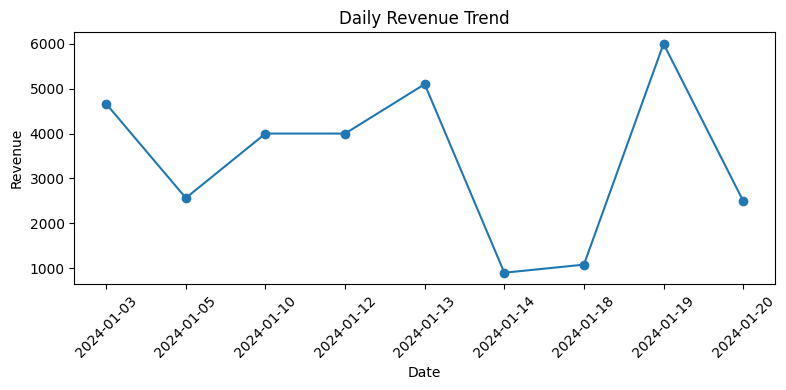

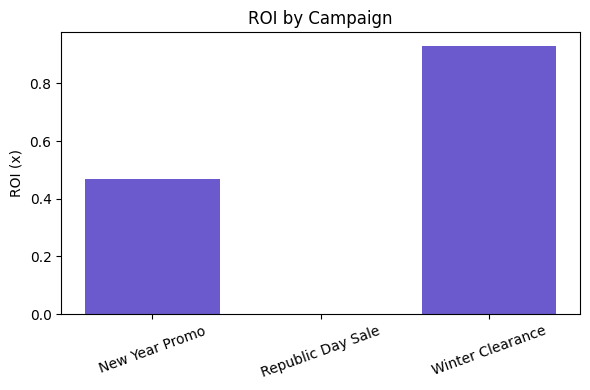

In [26]:
# 12) Visualization section (optional but great for Kaggle presentation)

daily = sql("SELECT * FROM v_daily_kpis;")
plt.figure(figsize=(8,4))
plt.plot(daily["order_day"], daily["total_revenue"], marker="o")
plt.title("Daily Revenue Trend")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

roi = sql("SELECT campaign_name, roi FROM v_campaign_performance;")
plt.figure(figsize=(6,4))
plt.bar(roi["campaign_name"], roi["roi"], color="#6A5ACD")
plt.title("ROI by Campaign")
plt.xticks(rotation=20)
plt.ylabel("ROI (x)")
plt.tight_layout()
plt.show()
